In [ ]:
!pip install pymongo tqdm plotly -q

# ============================================
# IMPORTAR LIBRERÍAS
# ============================================

import os
import pymongo
from urllib.parse import quote_plus
import hashlib
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import json

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Librerías importadas correctamente\n")

# ============================================
# MONTAR GOOGLE DRIVE
# ============================================

from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive montado correctamente\n")

# ============================================
# FUNCIONES AUXILIARES
# ============================================

def normalizar_keyword(kw):
    """Normaliza una keyword a minúsculas y sin espacios extra"""
    if pd.isna(kw):
        return None
    return str(kw).strip().lower()

def contiene_reacondicionado(keyword):
    """Verifica si la keyword contiene términos relacionados con reacondicionado"""
    if not keyword:
        return False
    keyword_lower = keyword.lower()
    terminos = ['reacondicionado', 'refurbished', 'renewed', 'restaurado',
                'segunda mano', 'usado', 'seminuevo', 'como nuevo']
    return any(termino in keyword_lower for termino in terminos)

def procesar_numero(value):
    """Convierte valores numéricos manejando NaN"""
    if pd.isna(value):
        return None
    try:
        return int(float(value))
    except:
        return None

def detectar_marca(keyword):
    """Detecta la marca del celular en la keyword"""
    if not keyword:
        return "otro"

    kw = keyword.lower()
    marcas = {
        'apple': ['iphone', 'apple'],
        'samsung': ['samsung', 'galaxy'],
        'xiaomi': ['xiaomi', 'redmi', 'poco'],
        'huawei': ['huawei', 'honor'],
        'motorola': ['motorola', 'moto'],
        'nokia': ['nokia'],
        'lg': ['lg'],
        'sony': ['sony', 'xperia'],
        'oneplus': ['oneplus'],
        'oppo': ['oppo'],
        'vivo': ['vivo'],
        'realme': ['realme']
    }

    for marca, palabras in marcas.items():
        if any(p in kw for p in palabras):
            return marca

    return "otro"

def generar_hash_corto(texto):
    """Genera hash de 16 caracteres para ahorrar espacio"""
    hash_completo = hashlib.sha256(str(texto).encode('utf-8')).hexdigest()
    return hash_completo[:16]

print("✅ Funciones auxiliares definidas\n")

# ============================================
# PASO 1: CONECTAR A MONGODB
# ============================================

print("=" * 60)
print("🔌 PASO 1: CONECTANDO A MONGODB")
print("=" * 60)

pass_mongo = "xxxxxxx"

username = quote_plus('xxxxxx_db_user')
password = quote_plus(pass_mongo)
cluster = 'xxxxx'
authSource = 'admin'
authMechanism = 'SCRAM-SHA-1'

uri = f'mongodb+srv://{username}:{password}@{cluster}/?authSource={authSource}&authMechanism={authMechanism}'

try:
    client = pymongo.MongoClient(uri, serverSelectionTimeoutMS=5000)
    client.server_info()

    db = client['celulares']
    collection = db['celulares_keywords']

    print(f"\n✅ Conectado a MongoDB exitosamente")
    print(f"📊 Base de datos: {db.name}")
    print(f"📁 Colección: {collection.name}")

    # Verificar documentos existentes
    docs_existentes = collection.count_documents({})
    print(f"📄 Documentos actuales: {docs_existentes:,}")

    # LIMPIAR COLECCIÓN SI ES NECESARIO
    if docs_existentes > 0:
        print(f"\n⚠️  Hay {docs_existentes:,} documentos en la colección")
        limpiar = input("¿Deseas eliminarlos para empezar limpio? (s/n): ")
        if limpiar.lower() == 's':
            collection.delete_many({})
            print("🗑️  Colección limpiada exitosamente")
        else:
            print("📌 Manteniendo documentos existentes")

    print()

except Exception as e:
    print(f"\n❌ Error conectando a MongoDB: {e}")
    raise

# ============================================
# PASO 2: CARGAR Y FILTRAR DATOS
# ============================================

print("=" * 60)
print("📂 PASO 2: CARGANDO Y FILTRANDO DATOS (PROCESO ETL)")
print("=" * 60)

carpeta = 'xxxxxxxxxxxxxxxxxxxx'

print(f"\n📁 Carpeta de trabajo: {carpeta}")
print(f"📄 Archivos disponibles:")
for archivo in os.listdir(carpeta):
    if archivo.endswith('.csv'):
        print(f"   • {archivo}")

print("\n🔍 Filtrando solo keywords con términos de 'reacondicionado'...\n")

dataframes_filtrados = []

# ===== SEMRUSH =====
try:
    print("Procesando Semrush...")
    df = pd.read_csv(f'{carpeta}/semrush.csv')
    df['keyword_norm'] = df['Keyword'].apply(normalizar_keyword)
    df['es_reacond'] = df['keyword_norm'].apply(contiene_reacondicionado)
    df_filtrado = df[df['es_reacond']].copy()

    df_filtrado['source'] = 'Semrush'
    df_filtrado['volume'] = df_filtrado['Volume'].apply(procesar_numero)
    df_filtrado = df_filtrado[['keyword_norm', 'source', 'volume']].dropna(subset=['keyword_norm'])

    dataframes_filtrados.append(df_filtrado)
    print(f"✅ Semrush: {len(df_filtrado):,} keywords reacondicionados (de {len(df):,} totales)")
except Exception as e:
    print(f"❌ Error con Semrush: {e}")

# ===== SIMILARWEB =====
try:
    print("Procesando SimilarWeb...")
    df = pd.read_csv(f'{carpeta}/similarweb.csv')
    df['keyword_norm'] = df['Keywords'].apply(normalizar_keyword)
    df['es_reacond'] = df['keyword_norm'].apply(contiene_reacondicionado)
    df_filtrado = df[df['es_reacond']].copy()

    df_filtrado['source'] = 'SimilarWeb'
    df_filtrado['volume'] = df_filtrado['Volume'].apply(procesar_numero)
    df_filtrado = df_filtrado[['keyword_norm', 'source', 'volume']].dropna(subset=['keyword_norm'])

    dataframes_filtrados.append(df_filtrado)
    print(f"✅ SimilarWeb: {len(df_filtrado):,} keywords reacondicionados (de {len(df):,} totales)")
except Exception as e:
    print(f"❌ Error con SimilarWeb: {e}")

# ===== RYTE =====
try:
    print("Procesando Ryte...")
    df = pd.read_csv(f'{carpeta}/ryte.csv')
    df['keyword_norm'] = df['Keyword'].apply(normalizar_keyword)
    df['es_reacond'] = df['keyword_norm'].apply(contiene_reacondicionado)
    df_filtrado = df[df['es_reacond']].copy()

    df_filtrado['source'] = 'Ryte'
    df_filtrado['volume'] = df_filtrado['Searches'].apply(procesar_numero)
    df_filtrado = df_filtrado[['keyword_norm', 'source', 'volume']].dropna(subset=['keyword_norm'])

    dataframes_filtrados.append(df_filtrado)
    print(f"✅ Ryte: {len(df_filtrado):,} keywords reacondicionados (de {len(df):,} totales)")
except Exception as e:
    print(f"❌ Error con Ryte: {e}")

# ===== AHREFS =====
try:
    print("Procesando Ahrefs...")
    df = pd.read_csv(f'{carpeta}/ahrefs.csv')
    df['keyword_norm'] = df['Keyword'].apply(normalizar_keyword)
    df['es_reacond'] = df['keyword_norm'].apply(contiene_reacondicionado)
    df_filtrado = df[df['es_reacond']].copy()

    df_filtrado['source'] = 'Ahrefs'
    df_filtrado['volume'] = df_filtrado['Volume'].apply(procesar_numero)
    df_filtrado = df_filtrado[['keyword_norm', 'source', 'volume']].dropna(subset=['keyword_norm'])

    dataframes_filtrados.append(df_filtrado)
    print(f"✅ Ahrefs: {len(df_filtrado):,} keywords reacondicionados (de {len(df):,} totales)")
except Exception as e:
    print(f"❌ Error con Ahrefs: {e}")

# Combinar todos los DataFrames
if len(dataframes_filtrados) == 0:
    print("\n❌ ERROR: No se pudo cargar ningún archivo CSV")
    print("Verifica las rutas y que los archivos contengan keywords con 'reacondicionado'")
else:
    df_combinado = pd.concat(dataframes_filtrados, ignore_index=True)
    print(f"\n📊 Total combinado: {len(df_combinado):,} registros")
    print(f"📊 Keywords únicas: {df_combinado['keyword_norm'].nunique():,}")

    print(f"\n📄 Muestra de datos combinados:")
    print(df_combinado.head(10))

# ============================================
# PASO 3: ESTRUCTURA DEL DOCUMENTO MONGODB
# ============================================

print("\n" + "=" * 60)
print("📋 PASO 3: ESTRUCTURA DEL DOCUMENTO MONGODB")
print("=" * 60)

estructura_optimizada = {
    "_id": "abc123def456",
    "kw": "iphone 13 reacondicionado",
    "m": "apple",
    "s": [
        {"n": "Semrush", "v": 15000},
        {"n": "Ahrefs", "v": 14500}
    ],
    "st": {
        "n": 2,
        "avg": 14750,
        "max": 15000,
        "tot": 29500
    }
}

print("\n📝 Estructura optimizada del documento (ahorra ~70% de espacio):\n")
print(json.dumps(estructura_optimizada, indent=2, ensure_ascii=False))

print("\n💡 Beneficios de esta estructura:")
print("   • Campos con nombres cortos (kw, m, s, st)")
print("   • Solo datos esenciales (sin métricas extra)")
print("   • Hash ID de 16 caracteres en lugar de 64")
print("   • Volúmenes como enteros (int) en lugar de float")

# ============================================
# PASO 4: INSERTAR DATOS EN MONGODB
# ============================================

print("\n" + "=" * 60)
print("📥 PASO 4: INSERTANDO DATOS EN MONGODB")
print("=" * 60)

if len(dataframes_filtrados) == 0 or len(df_combinado) == 0:
    print("\n❌ No hay datos para insertar. Verifica el paso anterior.")
else:
    contador_nuevos = 0
    contador_actualizados = 0
    errores = 0
    espacio_error = False

    print(f"\nInsertando {df_combinado['keyword_norm'].nunique():,} keywords únicos...\n")

    for keyword, grupo in tqdm(df_combinado.groupby('keyword_norm'), desc="Procesando"):
        try:
            doc_id = generar_hash_corto(keyword)

            # Crear lista de sources
            sources = []
            volumes = []

            for _, row in grupo.iterrows():
                vol = row['volume']
                if vol is not None and vol > 0:
                    sources.append({"n": row['source'], "v": int(vol)})
                    volumes.append(vol)

            # Calcular estadísticas
            if volumes:
                stats = {
                    "n": len(sources),
                    "avg": int(np.mean(volumes)),
                    "max": int(np.max(volumes)),
                    "tot": int(np.sum(volumes))
                }
            else:
                stats = {"n": len(sources), "avg": 0, "max": 0, "tot": 0}

            # Crear documento optimizado
            documento = {
                "_id": doc_id,
                "kw": keyword,
                "m": detectar_marca(keyword),
                "s": sources,
                "st": stats
            }

            # Insertar o actualizar
            resultado = collection.replace_one(
                {"_id": doc_id},
                documento,
                upsert=True
            )

            if resultado.upserted_id:
                contador_nuevos += 1
            else:
                contador_actualizados += 1

        except Exception as e:
            errores += 1
            error_msg = str(e)

            if errores <= 3:
                print(f"\n❌ Error: {error_msg[:150]}")

            if "space quota" in error_msg.lower():
                print("\n🛑 LÍMITE DE ESPACIO ALCANZADO")
                print("⚠️  El cluster gratuito de MongoDB ha llegado a 512 MB")
                espacio_error = True
                break

    print("\n" + "=" * 60)
    print("✅ INSERCIÓN COMPLETADA")
    print("=" * 60)
    print(f"📝 Documentos nuevos: {contador_nuevos:,}")
    print(f"🔄 Documentos actualizados: {contador_actualizados:,}")
    print(f"❌ Errores: {errores:,}")

    total_docs = collection.count_documents({})
    print(f"📊 Total en colección: {total_docs:,}")

    if espacio_error:
        print("\n⚠️  RECOMENDACIÓN: Si necesitas insertar más datos:")
        print("   1. Elimina documentos antiguos: collection.delete_many({})")
        print("   2. Considera usar MongoDB Atlas con plan de pago")
        print("   3. O filtra aún más los datos (solo top keywords)")

# ============================================
# PASO 5: VERIFICACIÓN DE DATOS
# ============================================

print("\n" + "=" * 60)
print("🔍 PASO 5: VERIFICACIÓN DE DATOS INSERTADOS")
print("=" * 60)

total_docs = collection.count_documents({})

if total_docs == 0:
    print("\n⚠️  No hay documentos en la colección")
    print("Verifica que el paso de inserción se haya completado correctamente")
else:
    print(f"\n📊 Total de documentos: {total_docs:,}")

    print("\n📄 Ejemplos de documentos insertados:\n")
    ejemplos = list(collection.find().limit(5))

    for i, doc in enumerate(ejemplos, 1):
        print(f"Documento {i}:")
        print(f"  Keyword: '{doc['kw']}'")
        print(f"  Marca: {doc['m']}")
        print(f"  Fuentes: {doc['st']['n']}")
        print(f"  Vol. Promedio: {doc['st']['avg']:,}")
        print(f"  Sources:")
        for s in doc['s']:
            print(f"    - {s['n']}: {s['v']:,} búsquedas")
        print()

    # Estadísticas de la colección
    print("📈 Estadísticas generales:")

    # Top marcas
    pipeline_marcas = [
        {"$group": {"_id": "$m", "count": {"$sum": 1}}},
        {"$sort": {"count": -1}},
        {"$limit": 10}
    ]

    print("\nTop 10 marcas:")
    for marca in collection.aggregate(pipeline_marcas):
        print(f"  {marca['_id']}: {marca['count']:,} keywords")

    # Distribución por número de fuentes
    pipeline_sources = [
        {"$group": {"_id": "$st.n", "count": {"$sum": 1}}},
        {"$sort": {"_id": 1}}
    ]

    print("\nDistribución por número de fuentes:")
    for item in collection.aggregate(pipeline_sources):
        print(f"  {item['_id']} fuente(s): {item['count']:,} keywords")

# ============================================
# PASO 6: CONSULTAS EN MONGODB
# ============================================

print("\n" + "=" * 60)
print("🔎 PASO 6: EJECUTANDO CONSULTAS EN MONGODB")
print("=" * 60)

if collection.count_documents({}) == 0:
    print("\n⚠️  No hay datos en la colección para consultar")
else:
    # CONSULTA 1: Regex simple
    print("\n📋 CONSULTA 1: Regex - Keywords con 'iphone reacondicionado'")
    print("-" * 60)

    query1 = {"kw": {"$regex": "iphone.*reacondicionado", "$options": "i"}}
    resultados_q1 = list(collection.find(query1).sort("st.avg", -1).limit(10))
    total_q1 = collection.count_documents(query1)

    print(f"Total encontrados: {total_q1:,}\n")
    print("Top 10 por volumen promedio:")
    for i, doc in enumerate(resultados_q1, 1):
        print(f"  {i}. {doc['kw']}")
        print(f"     Vol. Promedio: {doc['st']['avg']:,} | Fuentes: {doc['st']['n']}")

    # CONSULTA 2: Combinación lógica $and/$or
    print("\n\n📋 CONSULTA 2: $and/$or - 'reacondicionado' Y ('apple' O 'samsung') con avg > 1000")
    print("-" * 60)

    query2 = {
        "$and": [
            {"$or": [
                {"m": "apple"},
                {"m": "samsung"}
            ]},
            {"st.avg": {"$gt": 1000}}
        ]
    }

    resultados_q2 = list(collection.find(query2).sort("st.tot", -1).limit(10))
    total_q2 = collection.count_documents(query2)

    print(f"Total encontrados: {total_q2:,}\n")
    print("Top 10 por volumen total:")
    for i, doc in enumerate(resultados_q2, 1):
        print(f"  {i}. {doc['kw']}")
        print(f"     Marca: {doc['m']} | Vol. Total: {doc['st']['tot']:,}")

    # CONSULTA 3: Uso de $in para múltiples valores
    print("\n\n📋 CONSULTA 3: $in - Marcas premium con 2+ fuentes")
    print("-" * 60)

    query3 = {
        "m": {"$in": ["apple", "samsung", "xiaomi"]},
        "st.n": {"$gte": 2}
    }

    resultados_q3 = list(collection.find(query3).sort("st.avg", -1).limit(10))
    total_q3 = collection.count_documents(query3)

    print(f"Total encontrados: {total_q3:,}\n")
    print("Top 10 por volumen promedio:")
    for i, doc in enumerate(resultados_q3, 1):
        print(f"  {i}. {doc['kw']}")
        print(f"     Marca: {doc['m']} | Fuentes: {doc['st']['n']} | Vol. Avg: {doc['st']['avg']:,}")

    # CONSULTA 4: Regex con múltiples términos
    print("\n\n📋 CONSULTA 4: Regex - Múltiples términos relacionados")
    print("-" * 60)

    query4 = {
        "kw": {"$regex": "iphone (13|14|15).*reacondicionado", "$options": "i"}
    }

    resultados_q4 = list(collection.find(query4).sort("st.tot", -1).limit(15))
    total_q4 = collection.count_documents(query4)

    print(f"Total encontrados: {total_q4:,}\n")
    print("Top 15 por volumen total:")
    for i, doc in enumerate(resultados_q4, 1):
        print(f"  {i}. {doc['kw']} - Vol: {doc['st']['tot']:,}")

    # CONSULTA 5: Aggregation Pipeline
    print("\n\n📋 CONSULTA 5: Aggregation - Top marcas por volumen promedio")
    print("-" * 60)

    pipeline5 = [
        {"$group": {
            "_id": "$m",
            "total_keywords": {"$sum": 1},
            "avg_volume": {"$avg": "$st.avg"},
            "total_volume": {"$sum": "$st.tot"}
        }},
        {"$sort": {"avg_volume": -1}},
        {"$limit": 10}
    ]

    resultados_q5 = list(collection.aggregate(pipeline5))

    print("Top 10 marcas:\n")
    for i, marca in enumerate(resultados_q5, 1):
        print(f"{i}. {marca['_id'].upper()}")
        print(f"   Keywords: {marca['total_keywords']:,}")
        print(f"   Vol. Promedio: {marca['avg_volume']:,.0f}")
        print(f"   Vol. Total: {marca['total_volume']:,.0f}\n")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 28.6 MB/s eta 0:00:00
✅ Librerías importadas correctamente

Mounted at /content/drive
✅ Google Drive montado correctamente

✅ Funciones auxiliares definidas

🔌 PASO 1: CONECTANDO A MONGODB

✅ Conectado a MongoDB exitosamente
📊 Base de datos: celulares
📁 Colección: celulares_keywords
📄 Documentos actuales: 712

⚠️  Hay 712 documentos en la colección
¿Deseas eliminarlos para empezar limpio? (s/n): s
🗑️  Colección limpiada exitosamente

📂 PASO 2: CARGANDO Y FILTRANDO DATOS (PROCESO ETL)

📁 Carpeta de trabajo: /content/drive/MyDrive/Posgrado/Ciencia de Datos/libreta_8/celulares_cluster/celulares_cluster
📄 Archivos disponibles:
   • semrush.csv
   • similarweb.csv
   • ryte.csv
   • ahrefs.csv

🔍 Filtrando solo keywords con términos de 'reacondicionado'...

Procesando Semrush...
✅ Semrush: 209 keywords reacondicionados (de 12,605 totales)
Procesando Similar

Procesando: 100%|██████████| 712/712 [01:03<00:00, 11.19it/s]



✅ INSERCIÓN COMPLETADA
📝 Documentos nuevos: 712
🔄 Documentos actualizados: 0
❌ Errores: 0
📊 Total en colección: 712

🔍 PASO 5: VERIFICACIÓN DE DATOS INSERTADOS

📊 Total de documentos: 712

📄 Ejemplos de documentos insertados:

Documento 1:
  Keyword: 'a que se refiere iphone reacondicionado'
  Marca: apple
  Fuentes: 1
  Vol. Promedio: 10
  Sources:
    - Ahrefs: 10 búsquedas

Documento 2:
  Keyword: 'a que se refiere un celular reacondicionado'
  Marca: otro
  Fuentes: 1
  Vol. Promedio: 10
  Sources:
    - Ahrefs: 10 búsquedas

Documento 3:
  Keyword: 'amazon iphone 12 reacondicionado'
  Marca: apple
  Fuentes: 1
  Vol. Promedio: 1
  Sources:
    - SimilarWeb: 1 búsquedas

Documento 4:
  Keyword: 'amazon iphone reacondicionado'
  Marca: apple
  Fuentes: 1
  Vol. Promedio: 490
  Sources:
    - SimilarWeb: 490 búsquedas

Documento 5:
  Keyword: 'amazon reacondicionados iphone'
  Marca: apple
  Fuentes: 1
  Vol. Promedio: 170
  Sources:
    - Semrush: 170 búsquedas

📈 Estadísticas gene


📊 PASO 7: PREPARANDO DATOS PARA VISUALIZACIÓN

✅ Extraídos 712 documentos de MongoDB

📈 Resumen estadístico:
       num_sources    avg_volume    max_volume  total_volume
count   712.000000    712.000000    712.000000    712.000000
mean      1.251404    243.797753    387.464888    693.778090
std       0.736814   1313.115019   2396.949704   4859.944845
min       0.000000      0.000000      0.000000      0.000000
25%       1.000000      2.000000      2.000000      2.000000
50%       1.000000     30.000000     40.000000     40.000000
75%       1.000000     90.000000    100.000000    110.000000
max       4.000000  24429.000000  40500.000000  97718.000000

📄 Primeras filas:
                                             keyword  marca  num_sources  \
0            a que se refiere iphone reacondicionado  apple            1   
1        a que se refiere un celular reacondicionado   otro            1   
2                   amazon iphone 12 reacondicionado  apple            1   
3                 

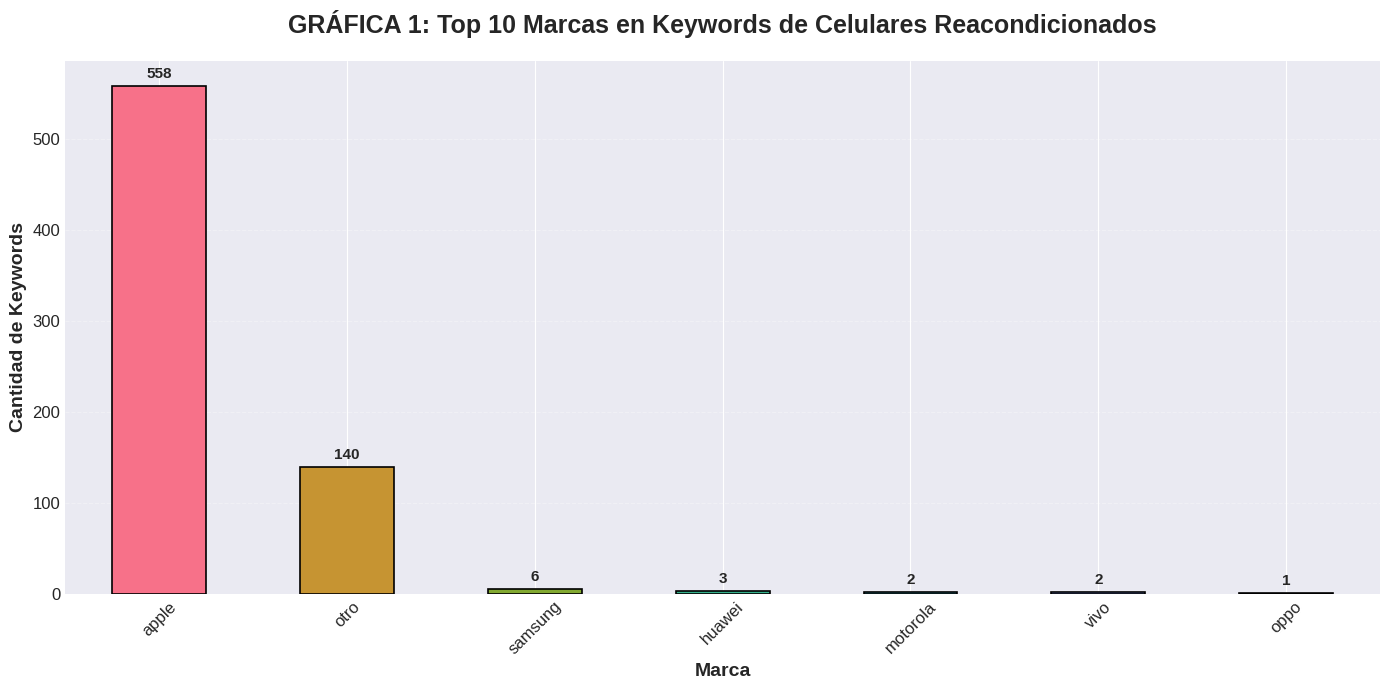


📊 GRÁFICA 2: DISTRIBUCIÓN DE VOLÚMENES DE BÚSQUEDA

📋 JUSTIFICACIÓN DE LA GRÁFICA:
   • Tipo: Histograma y Box Plot combinados
   • Propósito: Mostrar la distribución y tendencia de los volúmenes
     de búsqueda para entender el comportamiento del mercado
   • Utilidad: Identifica outliers (keywords muy buscados) y la
     distribución típica de búsquedas por marca
   • En Atlas Charts: Se puede filtrar por rango de fechas
     y marca para ver evolución temporal



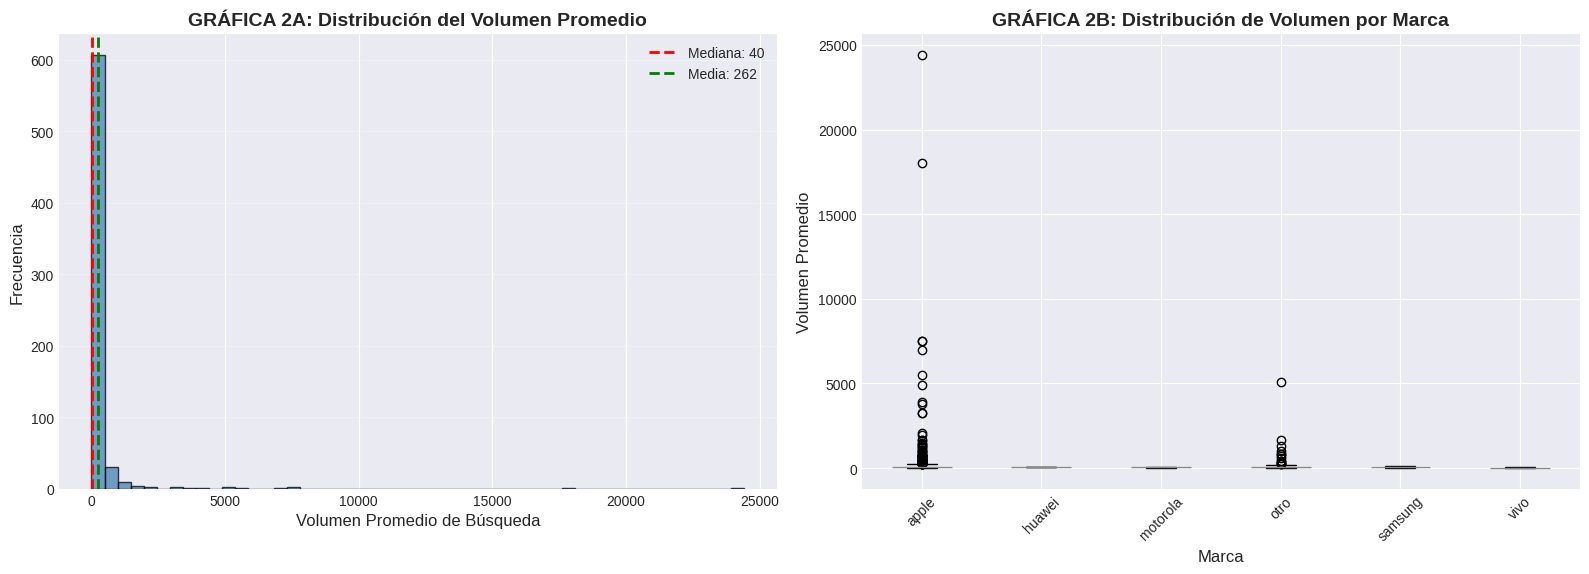


📊 GRÁFICA 3: TOP KEYWORDS POR VOLUMEN Y MARCA

📋 JUSTIFICACIÓN DE LA GRÁFICA:
   • Tipo: Gráfico de barras horizontales interactivo
   • Propósito: Mostrar la relación entre keywords específicos,
     su volumen total de búsqueda y la marca asociada
   • Utilidad: Permite identificar los términos más rentables
     para estrategias de SEO y marketing digital
   • Interactividad: Hover muestra detalles exactos, colores
     diferencian marcas visualmente
   • En Atlas Charts: Filtros por marca y volumen mínimo




📊 GRÁFICA 4: VOLUMEN VS NÚMERO DE FUENTES (DRILL-DOWN)

📋 JUSTIFICACIÓN DE LA GRÁFICA:
   • Tipo: Gráfico de barras agrupadas con doble eje Y
   • Propósito: Realizar drill-down mostrando la relación entre
     el número de fuentes que reportan una keyword y su volumen
   • Utilidad: Keywords reportadas por múltiples fuentes son más
     confiables. Esta gráfica muestra si mayor consenso = mayor volumen
   • Agregación: Agrupa por num_sources y calcula promedios/totales
   • En Atlas Charts: Se puede hacer drill-down por marca y fuente



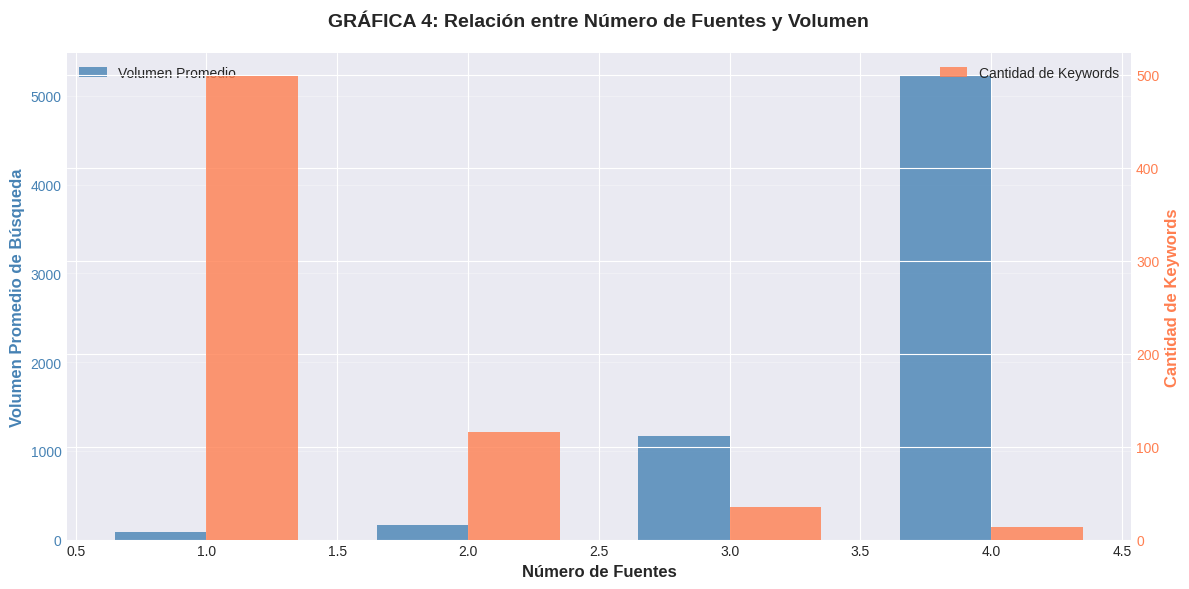


📊 GRÁFICA 5: KPI - VOLUMEN TOTAL POR MARCA (TREEMAP)

📋 JUSTIFICACIÓN DE LA GRÁFICA:
   • Tipo: Treemap (mapa de árbol)
   • Propósito: Mostrar el KPI principal 'Volumen Total de Búsqueda'
     distribuido proporcionalmente por marca
   • Utilidad: Visualización jerárquica que permite ver de un vistazo
     qué marcas acumulan más búsquedas (área = volumen)
   • KPI: El volumen total es un indicador clave para priorizar
     inversión en inventario y marketing por marca
   • En Atlas Charts: Filtros por rango de volumen y región




📊 PASO 9: ANÁLISIS FINAL Y ESTADÍSTICAS

🎯 RESUMEN EJECUTIVO:
------------------------------------------------------------

📈 Métricas Generales:
   • Total de keywords reacondicionados: 712
   • Volumen total de búsqueda: 493,970
   • Volumen promedio por keyword: 244
   • Marca más buscada: APPLE (558 keywords)

🏆 Top 5 Keywords Más Buscados:
   1. 'iphone reacondicionado' (apple) - 97,718 búsquedas
   2. 'iphone 13 reacondicionado' (apple) - 54,054 búsquedas
   3. 'iphone 12 reacondicionado' (apple) - 30,158 búsquedas
   4. 'iphone 14 reacondicionado' (apple) - 30,003 búsquedas
   5. 'iphone 11 reacondicionado' (apple) - 27,990 búsquedas

📊 Distribución por Número de Fuentes:
   • 0 fuente(s): 49 keywords (6.9%)
   • 1 fuente(s): 498 keywords (69.9%)
   • 2 fuente(s): 116 keywords (16.3%)
   • 3 fuente(s): 35 keywords (4.9%)
   • 4 fuente(s): 14 keywords (2.0%)

🎯 Top 5 Marcas por Volumen Total:
   • APPLE: 443,403 búsquedas (89.8%)
   • OTRO: 49,140 búsquedas (9.9%)
   • SAMSUNG: 

In [ ]:
# ============================================
# PASO 7: PREPARAR DATOS PARA VISUALIZACIÓN
# ============================================

print("\n" + "=" * 60)
print("📊 PASO 7: PREPARANDO DATOS PARA VISUALIZACIÓN")
print("=" * 60)

total_docs = collection.count_documents({})

if total_docs == 0:
    print("\n❌ No hay datos en MongoDB para visualizar")
    print("Asegúrate de que el paso de inserción se completó correctamente")
    df_viz = pd.DataFrame()
else:
    # Extraer todos los documentos
    datos_mongo = list(collection.find())

    print(f"\n✅ Extraídos {len(datos_mongo):,} documentos de MongoDB")

    # Convertir a DataFrame
    df_viz = pd.DataFrame([
        {
            'keyword': doc['kw'],
            'marca': doc.get('m', 'otro'),
            'num_sources': doc.get('st', {}).get('n', 0),
            'avg_volume': doc.get('st', {}).get('avg', 0),
            'max_volume': doc.get('st', {}).get('max', 0),
            'total_volume': doc.get('st', {}).get('tot', 0)
        }
        for doc in datos_mongo
    ])

    # Limpiar datos
    df_viz = df_viz.fillna(0)

    print("\n📈 Resumen estadístico:")
    print(df_viz.describe())

    print("\n📄 Primeras filas:")
    print(df_viz.head(10))

    print(f"\n📊 Información del DataFrame:")
    print(f"   • Total keywords: {len(df_viz):,}")
    print(f"   • Marcas únicas: {df_viz['marca'].nunique()}")
    print(f"   • Keywords con volumen > 0: {len(df_viz[df_viz['avg_volume'] > 0]):,}")

# ============================================
# PASO 8: VISUALIZACIONES DEL DASHBOARD
# ============================================

print("\n" + "=" * 60)
print("📊 PASO 8: GENERANDO VISUALIZACIONES DEL DASHBOARD")
print("📋 (Mínimo 5 gráficas requeridas según lineamientos)")
print("=" * 60)

if len(df_viz) == 0:
    print("\n⚠️  No hay datos para visualizar")
    print("Verifica que MongoDB contenga documentos")
else:
    # ============================================
    # GRÁFICA 1: Distribución de una variable categórica
    # Tipo: Gráfico de barras
    # Propósito: "Conteo de documentos por estado/categoría"
    # ============================================

    print("\n" + "=" * 60)
    print("📊 GRÁFICA 1: DISTRIBUCIÓN DE KEYWORDS POR MARCA")
    print("=" * 60)
    print("\n📋 JUSTIFICACIÓN DE LA GRÁFICA:")
    print("   • Tipo: Gráfico de barras verticales")
    print("   • Propósito: Mostrar la distribución categórica de keywords")
    print("     por marca de celular (Apple, Samsung, Xiaomi, etc.)")
    print("   • Utilidad: Permite identificar rápidamente qué marcas dominan")
    print("     el mercado de celulares reacondicionados en términos de búsquedas")
    print("   • En Atlas Charts: Se puede filtrar por marca específica")
    print("     y rango de volumen de búsqueda\n")

    fig1, ax1 = plt.subplots(figsize=(14, 7))
    marca_counts = df_viz['marca'].value_counts().head(10)

    colors = sns.color_palette("husl", len(marca_counts))
    marca_counts.plot(kind='bar', ax=ax1, color=colors, edgecolor='black', linewidth=1.2)

    ax1.set_title('GRÁFICA 1: Top 10 Marcas en Keywords de Celulares Reacondicionados',
                  fontsize=18, fontweight='bold', pad=20)
    ax1.set_xlabel('Marca', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Cantidad de Keywords', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45, labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')

    for i, v in enumerate(marca_counts.values):
        ax1.text(i, v + (marca_counts.max() * 0.01),
                str(v), ha='center', va='bottom',
                fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.show()

    # ============================================
    # GRÁFICA 2: Evolución temporal o de tendencia
    # Tipo: Histograma y Box Plot
    # Propósito: "Precio promedio a lo largo de los meses"
    # ============================================

    print("\n" + "=" * 60)
    print("📊 GRÁFICA 2: DISTRIBUCIÓN DE VOLÚMENES DE BÚSQUEDA")
    print("=" * 60)
    print("\n📋 JUSTIFICACIÓN DE LA GRÁFICA:")
    print("   • Tipo: Histograma y Box Plot combinados")
    print("   • Propósito: Mostrar la distribución y tendencia de los volúmenes")
    print("     de búsqueda para entender el comportamiento del mercado")
    print("   • Utilidad: Identifica outliers (keywords muy buscados) y la")
    print("     distribución típica de búsquedas por marca")
    print("   • En Atlas Charts: Se puede filtrar por rango de fechas")
    print("     y marca para ver evolución temporal\n")

    df_viz_filtered = df_viz[df_viz['avg_volume'] > 0]

    if len(df_viz_filtered) > 0:
        fig2, (ax2a, ax2b) = plt.subplots(1, 2, figsize=(16, 6))

        # Histograma
        ax2a.hist(df_viz_filtered['avg_volume'], bins=50,
                 edgecolor='black', alpha=0.75, color='steelblue')
        ax2a.set_title('GRÁFICA 2A: Distribución del Volumen Promedio',
                      fontsize=14, fontweight='bold')
        ax2a.set_xlabel('Volumen Promedio de Búsqueda', fontsize=12)
        ax2a.set_ylabel('Frecuencia', fontsize=12)
        ax2a.grid(axis='y', alpha=0.3)

        mediana = df_viz_filtered['avg_volume'].median()
        media = df_viz_filtered['avg_volume'].mean()
        ax2a.axvline(mediana, color='red', linestyle='--', linewidth=2,
                    label=f'Mediana: {mediana:,.0f}')
        ax2a.axvline(media, color='green', linestyle='--', linewidth=2,
                    label=f'Media: {media:,.0f}')
        ax2a.legend(fontsize=10)

        # Box plot por marca
        marcas_top = df_viz['marca'].value_counts().head(8).index
        df_viz_top = df_viz[df_viz['marca'].isin(marcas_top) & (df_viz['avg_volume'] > 0)]

        if len(df_viz_top) > 0:
            df_viz_top.boxplot(column='avg_volume', by='marca', ax=ax2b)
            ax2b.set_title('GRÁFICA 2B: Distribución de Volumen por Marca',
                          fontsize=14, fontweight='bold')
            ax2b.set_xlabel('Marca', fontsize=12)
            ax2b.set_ylabel('Volumen Promedio', fontsize=12)
            ax2b.tick_params(axis='x', rotation=45)
            plt.suptitle('')

        plt.tight_layout()
        plt.show()
    else:
        print("⚠️  No hay datos con volumen > 0 para histograma")

    # ============================================
    # GRÁFICA 3: Relación o correlación entre dos variables
    # Tipo: Gráfico de barras horizontales interactivo (Plotly)
    # Propósito: "Scatter plot de X vs Y"
    # ============================================

    print("\n" + "=" * 60)
    print("📊 GRÁFICA 3: TOP KEYWORDS POR VOLUMEN Y MARCA")
    print("=" * 60)
    print("\n📋 JUSTIFICACIÓN DE LA GRÁFICA:")
    print("   • Tipo: Gráfico de barras horizontales interactivo")
    print("   • Propósito: Mostrar la relación entre keywords específicos,")
    print("     su volumen total de búsqueda y la marca asociada")
    print("   • Utilidad: Permite identificar los términos más rentables")
    print("     para estrategias de SEO y marketing digital")
    print("   • Interactividad: Hover muestra detalles exactos, colores")
    print("     diferencian marcas visualmente")
    print("   • En Atlas Charts: Filtros por marca y volumen mínimo\n")

    top_keywords = df_viz.nlargest(20, 'total_volume')

    if len(top_keywords) > 0:
        fig3 = px.bar(
            top_keywords,
            x='total_volume',
            y='keyword',
            color='marca',
            orientation='h',
            title='GRÁFICA 3: Top 20 Keywords Reacondicionados por Volumen Total',
            labels={'total_volume': 'Volumen Total', 'keyword': 'Keyword'},
            color_discrete_sequence=px.colors.qualitative.Set3,
            height=600
        )

        fig3.update_layout(
            yaxis={'categoryorder': 'total ascending'},
            showlegend=True,
            xaxis_title="Volumen Total de Búsqueda",
            yaxis_title="Keyword",
            font=dict(size=10),
            title_font_size=16
        )

        fig3.show()
    else:
        print("⚠️  No hay suficientes datos para generar el gráfico")

    # ============================================
    # GRÁFICA 4: Agregación compleja o drill-down
    # Tipo: Gráfico de barras agrupadas con doble eje
    # Propósito: "Ventas por vendedor y producto"
    # ============================================

    print("\n" + "=" * 60)
    print("📊 GRÁFICA 4: VOLUMEN VS NÚMERO DE FUENTES (DRILL-DOWN)")
    print("=" * 60)
    print("\n📋 JUSTIFICACIÓN DE LA GRÁFICA:")
    print("   • Tipo: Gráfico de barras agrupadas con doble eje Y")
    print("   • Propósito: Realizar drill-down mostrando la relación entre")
    print("     el número de fuentes que reportan una keyword y su volumen")
    print("   • Utilidad: Keywords reportadas por múltiples fuentes son más")
    print("     confiables. Esta gráfica muestra si mayor consenso = mayor volumen")
    print("   • Agregación: Agrupa por num_sources y calcula promedios/totales")
    print("   • En Atlas Charts: Se puede hacer drill-down por marca y fuente\n")

    df_sources = df_viz[df_viz['avg_volume'] > 0].groupby('num_sources').agg({
        'avg_volume': ['mean', 'count'],
        'total_volume': 'sum'
    }).reset_index()

    if len(df_sources) > 0:
        df_sources.columns = ['num_sources', 'avg_volume_mean', 'count', 'total_volume']

        fig4, ax4 = plt.subplots(figsize=(12, 6))

        x = df_sources['num_sources']
        width = 0.35

        ax4_twin = ax4.twinx()

        bars1 = ax4.bar(x - width/2, df_sources['avg_volume_mean'], width,
                        label='Volumen Promedio', alpha=0.8, color='steelblue')
        bars2 = ax4_twin.bar(x + width/2, df_sources['count'], width,
                             label='Cantidad de Keywords', alpha=0.8, color='coral')

        ax4.set_xlabel('Número de Fuentes', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Volumen Promedio de Búsqueda', fontsize=12, color='steelblue', fontweight='bold')
        ax4_twin.set_ylabel('Cantidad de Keywords', fontsize=12, color='coral', fontweight='bold')
        ax4.set_title('GRÁFICA 4: Relación entre Número de Fuentes y Volumen',
                      fontsize=14, fontweight='bold', pad=20)

        ax4.tick_params(axis='y', labelcolor='steelblue')
        ax4_twin.tick_params(axis='y', labelcolor='coral')

        ax4.legend(loc='upper left')
        ax4_twin.legend(loc='upper right')
        ax4.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("⚠️  No hay datos suficientes para esta visualización")

    # ============================================
    # GRÁFICA 5: Indicador clave de rendimiento (KPI)
    # Tipo: Treemap
    # Propósito: "Total de ventas" o "Valor promedio"
    # ============================================

    print("\n" + "=" * 60)
    print("📊 GRÁFICA 5: KPI - VOLUMEN TOTAL POR MARCA (TREEMAP)")
    print("=" * 60)
    print("\n📋 JUSTIFICACIÓN DE LA GRÁFICA:")
    print("   • Tipo: Treemap (mapa de árbol)")
    print("   • Propósito: Mostrar el KPI principal 'Volumen Total de Búsqueda'")
    print("     distribuido proporcionalmente por marca")
    print("   • Utilidad: Visualización jerárquica que permite ver de un vistazo")
    print("     qué marcas acumulan más búsquedas (área = volumen)")
    print("   • KPI: El volumen total es un indicador clave para priorizar")
    print("     inversión en inventario y marketing por marca")
    print("   • En Atlas Charts: Filtros por rango de volumen y región\n")

    df_marcas_treemap = df_viz.groupby('marca').agg({
        'total_volume': 'sum',
        'keyword': 'count'
    }).reset_index()

    df_marcas_treemap.columns = ['marca', 'total_volume', 'num_keywords']
    df_marcas_treemap = df_marcas_treemap[df_marcas_treemap['total_volume'] > 0]

    if len(df_marcas_treemap) > 0:
        fig5 = px.treemap(
            df_marcas_treemap,
            path=['marca'],
            values='total_volume',
            title='GRÁFICA 5: KPI - Distribución de Volumen Total por Marca',
            color='total_volume',
            color_continuous_scale='Viridis',
            hover_data={'num_keywords': True, 'total_volume': ':,.0f'}
        )

        fig5.update_layout(
            title_font_size=16,
            height=600
        )

        fig5.show()
    else:
        print("⚠️  No hay datos suficientes para el treemap")

# ============================================
# PASO 9: ANÁLISIS FINAL Y RESUMEN EJECUTIVO
# ============================================

print("\n" + "=" * 60)
print("📊 PASO 9: ANÁLISIS FINAL Y ESTADÍSTICAS")
print("=" * 60)

print("\n🎯 RESUMEN EJECUTIVO:")
print("-" * 60)

total_reacondicionado = len(df_viz)
total_volumen = df_viz['total_volume'].sum()
promedio_volumen = df_viz['avg_volume'].mean()

if total_reacondicionado > 0:
    marca_dominante = df_viz['marca'].value_counts().index[0]
    keywords_marca_dominante = df_viz['marca'].value_counts().values[0]

    print(f"\n📈 Métricas Generales:")
    print(f"   • Total de keywords reacondicionados: {total_reacondicionado:,}")
    print(f"   • Volumen total de búsqueda: {total_volumen:,.0f}")
    print(f"   • Volumen promedio por keyword: {promedio_volumen:,.0f}")
    print(f"   • Marca más buscada: {marca_dominante.upper()} ({keywords_marca_dominante:,} keywords)")

    # Top 5 keywords más buscados
    print(f"\n🏆 Top 5 Keywords Más Buscados:")
    top_5 = df_viz.nlargest(5, 'total_volume')[['keyword', 'marca', 'total_volume']]
    for idx, (i, row) in enumerate(top_5.iterrows(), 1):
        print(f"   {idx}. '{row['keyword']}' ({row['marca']}) - {row['total_volume']:,.0f} búsquedas")

    # Distribución por número de fuentes
    print(f"\n📊 Distribución por Número de Fuentes:")
    sources_dist = df_viz['num_sources'].value_counts().sort_index()
    for num_sources, count in sources_dist.items():
        porcentaje = (count / total_reacondicionado) * 100
        print(f"   • {num_sources} fuente(s): {count:,} keywords ({porcentaje:.1f}%)")

    # Top marcas
    print(f"\n🎯 Top 5 Marcas por Volumen Total:")
    top_marcas = df_viz.groupby('marca')['total_volume'].sum().nlargest(5)
    for marca, volumen in top_marcas.items():
        if total_volumen > 0:
            porcentaje = (volumen / total_volumen) * 100
            print(f"   • {marca.upper()}: {volumen:,.0f} búsquedas ({porcentaje:.1f}%)")
else:
    print("\n⚠️  No hay datos suficientes para generar estadísticas")